In [1]:
# python.exe -m pip install --upgrade pip
# pip install --upgrade transformers datasets[audio] accelerate
# pip install --upgrade librosa
# pip install --upgrade evaluate
# pip install --upgrade jiwer
# pip install --upgrade matplotlib

In [2]:
import time
import evaluate
import librosa
import time
import evaluate
import jiwer
import soundfile as sf
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline, WhisperProcessor

c:\Users\beranger\anaconda3\envs\whisper\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
texte_original = "Il y avait déjà bien des années que, de Combray, tout ce qui n’était pas le théâtre et le drame de mon coucher n’existait plus pour moi, quand un jour d’hiver, comme je rentrais à la maison, ma mère, voyant que j’avais froid, me proposa de me faire prendre, contre mon habitude, un peu de thé. Je refusai d’abord et, je ne sais pourquoi, je me ravisai. Elle envoya chercher un de ces gâteaux courts et dodus appelés Petites Madeleines qui semblaient avoir été moulés dans la valve rainurée d’une coquille de Saint-Jacques. Et bientôt, machinalement, accablé par la morne journée et la perspective d’un triste lendemain, je portai à mes lèvres une cuillerée du thé où j’avais laissé s’amollir un morceau de madeleine. Mais à l’instant même où la gorgée mêlée des miettes du gâteau toucha mon palais, je tressaillis, attentif à ce qui se passait d’extraordinaire en moi. Un plaisir délicieux m’avait envahi, isolé, sans la notion de sa cause. Il m’avait aussitôt rendu les vicissitudes de la vie indifférentes, ses désastres inoffensifs, sa brièveté illusoire, de la même façon qu’opère l’amour, en me remplissant d’une essence précieuse : ou plutôt cette essence n’était pas en moi, elle était moi. J’avais cessé de me sentir médiocre, contingent, mortel. D’où avait pu me venir cette puissante joie ? Je sentais qu’elle était liée au goût du thé et du gâteau, mais qu’elle le dépassait infiniment, ne devait pas être de même nature. D’où venait-elle ? Que signifiait-elle ? Où l’appréhender ? Je bois une seconde gorgée où je ne trouve rien de plus que dans la première, une troisième qui m’apporte un peu moins que la seconde. Il est temps que je m’arrête, la vertu du breuvage semble diminuer. Il est clair que la vérité que je cherche n’est pas en lui, mais en moi. Il l’y a éveillée, mais ne la connaît pas, et ne peut que répéter indéfiniment, avec de moins en moins de force, ce même témoignage que je ne sais pas interpréter et que je veux au moins pouvoir lui redemander et retrouver intact à ma disposition, tout à l’heure, pour un éclaircissement décisif. Je pose la tasse et me tourne vers mon esprit. C’est à lui de trouver la vérité."

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

wer_metric = evaluate.load("wer")

model_ids = [
    "openai/whisper-tiny",
    "openai/whisper-base",
    "openai/whisper-small",
    "openai/whisper-medium",
    "openai/whisper-large",
    "openai/whisper-large-v2",
    "openai/whisper-large-v3",
    "openai/whisper-large-v3-turbo"
]

# Charger l'audio
audio_data_test, sr_test = librosa.load("test.wav", sr=16000)

results = []

for model in model_ids:
    print(f"Testing model {model}...")
    start_time = time.time()
    tmp_model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
    ).to(device)
    tmp_processor = AutoProcessor.from_pretrained(model)
    tmp_pipe = pipeline(
        "automatic-speech-recognition",
        model=tmp_model,
        tokenizer=tmp_processor.tokenizer,
        feature_extractor=tmp_processor.feature_extractor,
        torch_dtype=torch_dtype,
        device=device,
        return_timestamps=True
    )

    output = tmp_pipe(audio_data_test)
    elapsed = time.time() - start_time
    wer_value = wer_metric.compute(predictions=[output["text"]], references=[texte_original])

    results.append({
        "model_id": model.split("/")[-1],
        "transcription": output["text"],
        "wer": wer_value,
        "time_s": elapsed
    })

Testing model openai/whisper-tiny...


Device set to use cpu
c:\Users\beranger\anaconda3\envs\whisper\lib\site-packages\transformers\models\whisper\generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Testing model openai/whisper-base...


Device set to use cpu


Testing model openai/whisper-small...


Device set to use cpu
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


Testing model openai/whisper-medium...


Device set to use cpu


Testing model openai/whisper-large...


Device set to use cpu


Testing model openai/whisper-large-v2...


Device set to use cpu
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


Testing model openai/whisper-large-v3...


Device set to use cpu
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


Testing model openai/whisper-large-v3-turbo...


Device set to use cpu
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


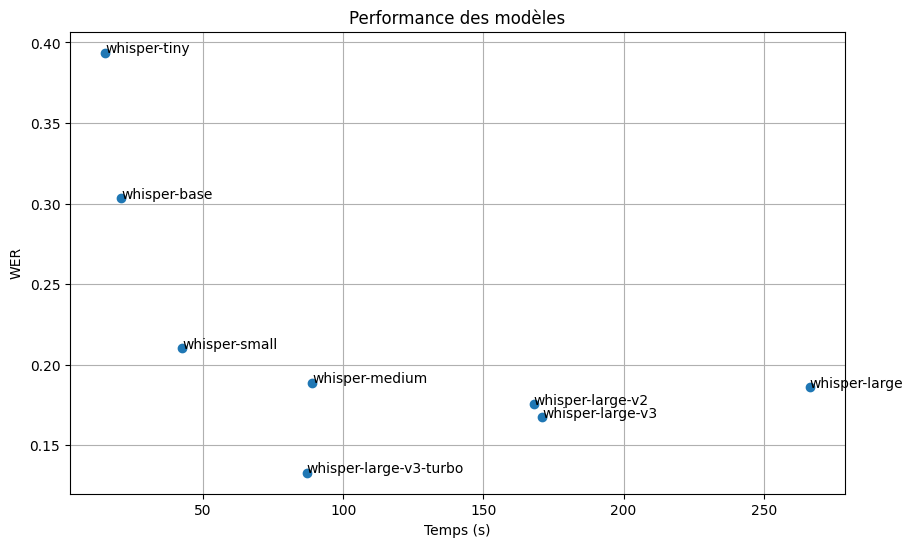

whisper-tiny - WER: 0.39 - Time: 15.11s
whisper-base - WER: 0.30 - Time: 20.81s
whisper-small - WER: 0.21 - Time: 42.51s
whisper-medium - WER: 0.19 - Time: 88.98s
whisper-large - WER: 0.19 - Time: 266.43s
whisper-large-v2 - WER: 0.18 - Time: 167.90s
whisper-large-v3 - WER: 0.17 - Time: 171.05s
whisper-large-v3-turbo - WER: 0.13 - Time: 87.01s


In [5]:
# afficher les modèles et leurs performances : model_id, wer et temps
# Affichage des résultats sous forme d'un nuage de points

# Extraire les WER et les temps pour chaque modèle
wer_values = [r["wer"] for r in results]
time_values = [r["time_s"] for r in results]
model_ids = [r["model_id"] for r in results]

# Créer un nuage de points
plt.figure(figsize=(10, 6))
plt.scatter(time_values, wer_values)

# Annoter chaque point avec le nom du modèle
for i, model_id in enumerate(model_ids):
    plt.annotate(model_id, (time_values[i], wer_values[i]))

plt.title("Performance des modèles")
plt.xlabel("Temps (s)")
plt.ylabel("WER")
plt.grid(True)
plt.show()

classement = sorted(results, key=lambda x: x["wer"])
for r in results:
    print(f"{r['model_id']} - WER: {r['wer']:.2f} - Time: {r['time_s']:.2f}s")